# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
!pip install matplotlib==2.0.2

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


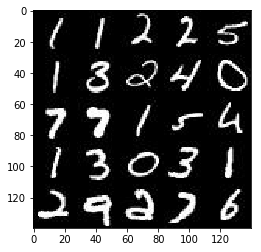

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

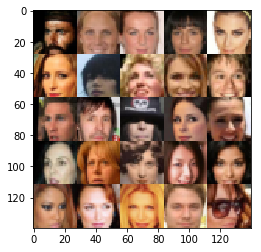

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_input_images')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name = 'tensor_z_data')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')   
    
    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2): #alpha 0.0001
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #dropout = 0.2
        initializer = tf.contrib.layers.xavier_initializer()
        d1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        d_relu1 = tf.maximum(d1*alpha, d1)
        #d_drop1 = tf.layers.dropout(d_relu1,rate=dropout)
        
        d2 = tf.layers.conv2d(d_relu1, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        d_bn2 = tf.layers.batch_normalization(d2, training=True)
        d_relu2 = tf.maximum(d_bn2*alpha, d_bn2)
        #d_drop = tf.layers.dropout(d_relu2,rate=dropout)
        
        d3 = tf.layers.conv2d(d_relu2, 256, 5, strides=2, padding='same', kernel_initializer=initializer)
        d_bn3 = tf.layers.batch_normalization(d3, training=True)
        d_relu3 = tf.maximum(d_bn3*alpha, d_bn3)
        
        #flatten = tf.reshape(d_relu3, (-1,4*4*256))
        flatten = tf.contrib.layers.flatten(d_relu3)
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.08): #alpha 0.0001
     with tf.variable_scope('generator', reuse=not is_train):
        #dropout = 0.1
        # First fully connected layer
        g_initializer = tf.contrib.layers.xavier_initializer()
        g_full = tf.layers.dense(z, 7*7*512)
        g_full = tf.reshape(g_full, (-1, 7, 7, 512))
        g_full = tf.layers.batch_normalization(g_full, training=is_train)
        g_full = tf.maximum(alpha * g_full, g_full)
        # 4x4x512 now
        
        g0 = tf.layers.conv2d_transpose(g_full, 1024, 5, strides=1, padding='same')
        g0 = tf.layers.batch_normalization(g0, training=is_train)
        g0 = tf.maximum(alpha * g0, g0)
        
        g1 = tf.layers.conv2d_transpose(g0, 512, 5, strides=1, padding='same', kernel_initializer=g_initializer)
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.nn.relu(g1)
        #g1_drop = tf.layers.dropout(g1,rate=dropout)
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=1, padding='same', kernel_initializer=g_initializer)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.nn.relu(g2)
        #g2_drop = tf.layers.dropout(g2,rate=dropout)
        # 8x8x256 now
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', kernel_initializer=g_initializer)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.nn.relu(g3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=g_initializer)
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2): #alpha 0.0001, 0.08
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(#add smoothing
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like((d_model_real)*smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    images_grid = np.asarray(images_grid, dtype=np.uint8)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    real_images, z_data, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_images, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_loss_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_images: batch_images, z_data: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_data: batch_z, real_images: batch_images, lr:learning_rate})
                
                if steps % print_loss_every == 0:
                    train_loss_d = d_loss.eval({z_data: batch_z, real_images: batch_images})
                    train_loss_g = g_loss.eval({z_data: batch_z})
                    
                    print("Step {}/{}...".format(steps, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 24, z_data, data_shape[3], data_image_mode)
                    
                   
               
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 50/1... Discriminator Loss: 0.1668... Generator Loss: 4.2675
Step 100/1... Discriminator Loss: 1.6838... Generator Loss: 0.5393


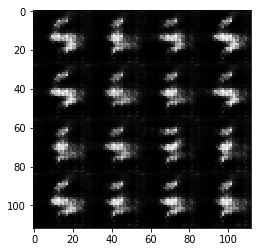

Step 150/1... Discriminator Loss: 1.0618... Generator Loss: 1.6190
Step 200/1... Discriminator Loss: 0.8422... Generator Loss: 1.2244


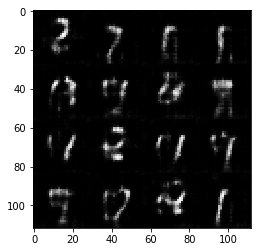

Step 250/1... Discriminator Loss: 1.0684... Generator Loss: 0.8625
Step 300/1... Discriminator Loss: 1.2388... Generator Loss: 0.7718


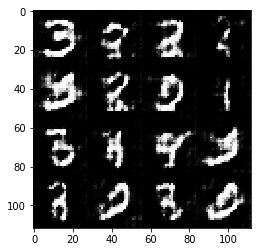

Step 350/1... Discriminator Loss: 1.2976... Generator Loss: 0.7144
Step 400/1... Discriminator Loss: 1.4983... Generator Loss: 0.4254


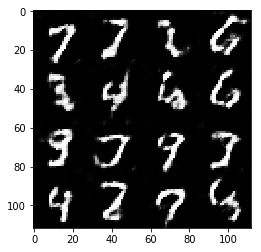

Step 450/1... Discriminator Loss: 1.4308... Generator Loss: 0.5218
Step 500/2... Discriminator Loss: 1.3111... Generator Loss: 1.3089


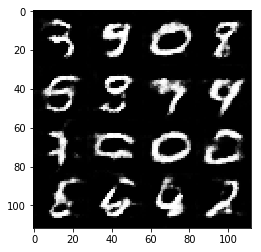

Step 550/2... Discriminator Loss: 1.2983... Generator Loss: 1.0796
Step 600/2... Discriminator Loss: 1.5370... Generator Loss: 0.5176


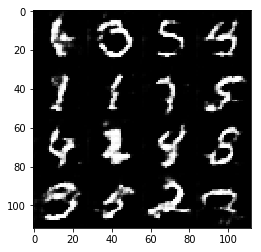

Step 650/2... Discriminator Loss: 1.2423... Generator Loss: 0.7530
Step 700/2... Discriminator Loss: 1.2393... Generator Loss: 1.0379


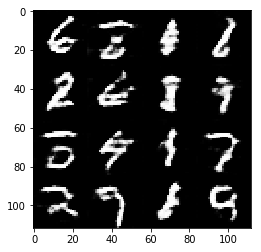

Step 750/2... Discriminator Loss: 1.2429... Generator Loss: 0.8199
Step 800/2... Discriminator Loss: 1.3104... Generator Loss: 0.8328


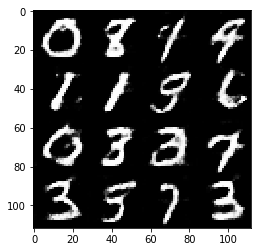

Step 850/2... Discriminator Loss: 1.3204... Generator Loss: 0.6232
Step 900/2... Discriminator Loss: 1.2575... Generator Loss: 0.7926


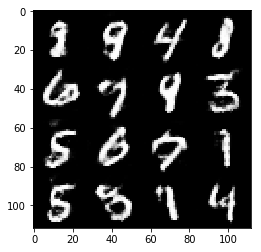

In [13]:
batch_size =  128
z_dim = 100
learning_rate = 0.0008#0.0002#0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 50/1... Discriminator Loss: 1.3609... Generator Loss: 0.7770
Step 100/1... Discriminator Loss: 1.3764... Generator Loss: 0.6896


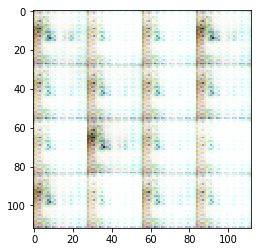

Step 150/1... Discriminator Loss: 2.6006... Generator Loss: 0.1496
Step 200/1... Discriminator Loss: 1.3247... Generator Loss: 0.6913


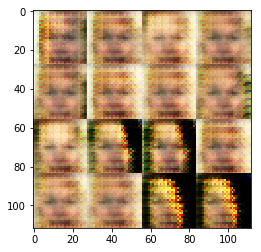

Step 250/1... Discriminator Loss: 0.8574... Generator Loss: 1.2375
Step 300/1... Discriminator Loss: 1.1645... Generator Loss: 0.5794


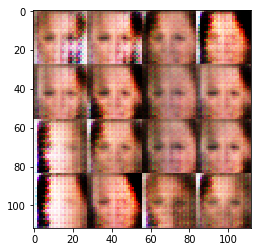

Step 350/1... Discriminator Loss: 1.0742... Generator Loss: 1.2647
Step 400/1... Discriminator Loss: 1.0083... Generator Loss: 0.9098


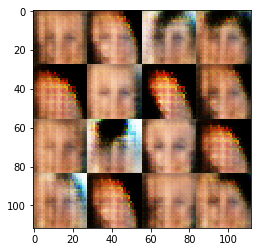

Step 450/1... Discriminator Loss: 0.6231... Generator Loss: 2.0712
Step 500/1... Discriminator Loss: 0.9181... Generator Loss: 1.1090


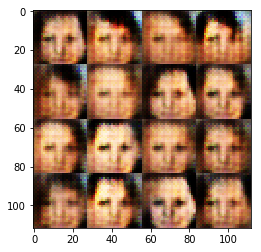

Step 550/1... Discriminator Loss: 0.7768... Generator Loss: 1.3310
Step 600/1... Discriminator Loss: 0.9437... Generator Loss: 1.0636


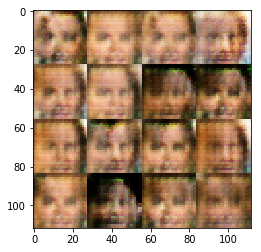

Step 650/1... Discriminator Loss: 1.1865... Generator Loss: 1.1860
Step 700/1... Discriminator Loss: 0.6484... Generator Loss: 2.1881


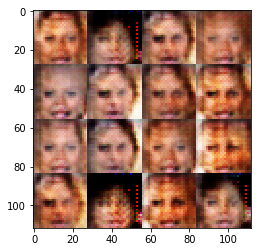

Step 750/1... Discriminator Loss: 0.6957... Generator Loss: 1.2256
Step 800/1... Discriminator Loss: 3.2630... Generator Loss: 5.7999


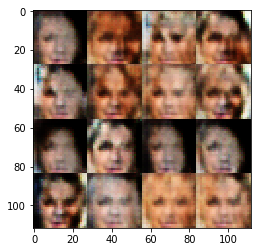

Step 850/1... Discriminator Loss: 0.5207... Generator Loss: 2.3469
Step 900/1... Discriminator Loss: 0.9969... Generator Loss: 2.4460


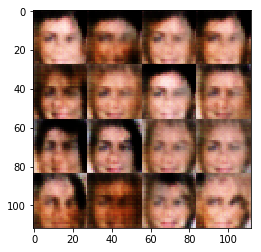

Step 950/1... Discriminator Loss: 0.6815... Generator Loss: 2.1850
Step 1000/1... Discriminator Loss: 0.3555... Generator Loss: 2.0565


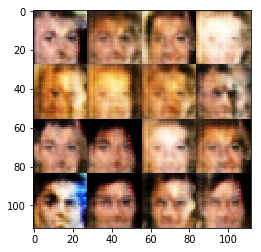

Step 1050/1... Discriminator Loss: 0.3993... Generator Loss: 2.0082
Step 1100/1... Discriminator Loss: 0.7243... Generator Loss: 2.7227


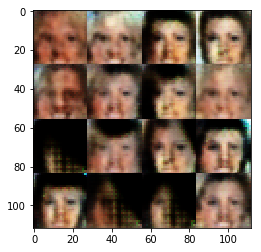

Step 1150/1... Discriminator Loss: 0.4475... Generator Loss: 1.3868
Step 1200/1... Discriminator Loss: 1.0839... Generator Loss: 2.6243


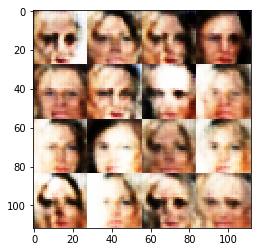

Step 1250/1... Discriminator Loss: 1.4374... Generator Loss: 4.4577
Step 1300/1... Discriminator Loss: 0.8612... Generator Loss: 3.1734


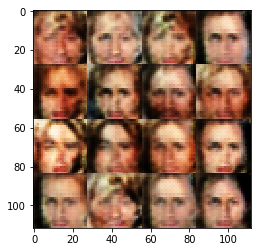

Step 1350/1... Discriminator Loss: 0.3977... Generator Loss: 2.8253
Step 1400/1... Discriminator Loss: 0.9361... Generator Loss: 3.0371


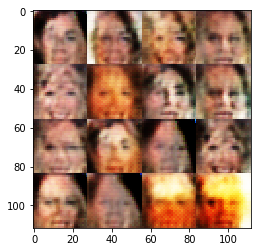

Step 1450/1... Discriminator Loss: 0.8652... Generator Loss: 1.5590
Step 1500/1... Discriminator Loss: 0.4455... Generator Loss: 2.2222


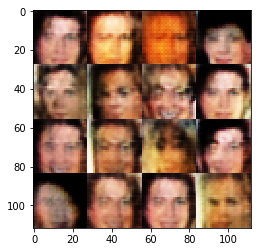

Step 1550/1... Discriminator Loss: 0.1839... Generator Loss: 2.9102


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.